In [24]:
import os
from pathlib import Path
from math import log, sqrt, pi, exp, floor
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime, date, timedelta
import numpy as np
from yahoo_fin import options
from yahoo_fin import stock_info as si

In [25]:
### American option pricers (Binomial Tree) ###
def binomial_american_call_pricer (S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = 1./u
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector of lumpy dividends
    dividend = np.zeros(N + 1)

    if t_q > 0 and t_q <= t:
        div_index = int(floor(t_q/t * N))

        for n in range(div_index):
            dividend[n] = q / (R ** (div_index - n))


    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for n in range(N + 1):
        for j in range(n + 1):
            stock[n, j] = (S - dividend[0]) * (u ** j) * (d ** (n - j)) + dividend[n]

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[N, :] = np.maximum(np.zeros(N + 1), stock[N, :] - K)

    for n in range(N - 1, -1, -1):
        for j in range(n + 1):
            option[n, j] = (
                 np.maximum(stock[n, j] - K, (p * option[n + 1, j + 1] + (1 - p) * option[n + 1, j]) / R)
            )

    return option[0, 0]

def binomial_american_put_pricer (S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = 1./u
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector of lumpy dividends
    dividend = np.zeros(N + 1)

    if t_q > 0 and t_q <= t :
        div_index = int(floor(t_q/t * N))

        for n in range(div_index):
            dividend[n] = q / (R ** (div_index - n))


    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for n in range(N + 1):
        for j in range(n + 1):
            stock[n, j] = (S - dividend[0]) * (u ** j) * (d ** (n - j)) + dividend[n]

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[N, :] = np.maximum(np.zeros(N + 1), K - stock[N, :])

    for n in range(N - 1, -1, -1):
        for j in range(n + 1):
            option[n, j] = (
                 np.maximum(K - stock[n, j], (p * option[n + 1, j + 1] + (1 - p) * option[n + 1, j]) / R)
            )

    return option[0, 0]

print(binomial_american_call_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=1.3759, N=10))
print(binomial_american_put_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=0, N=10))


10.824553031824337
3.07621086348687


In [26]:
### Binomial american implied volatility calculation formulas ###

def iv_binomial_american_call(S, K, t, t_q, r, q, N, call_market_price, a=0.01, b=2.0, xtol=1e-6):
    _S, _K, _t, _t_q, _r, _q, _N, _call_market_price = S, K, t, t_q, r, q, N, call_market_price
    
    # define a nested function with only volatility as input
    def call_iv_objective_func(vola):
        return _call_market_price - binomial_american_call_pricer(_S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(call_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan
    
def iv_binomial_american_put(S, K, t, t_q, r, q, N, put_market_price, a=0.01, b=2.0, xtol=1e-6):
    _S, _K, _t, _t_q, _r, _q, _N, _put_market_price = S, K, t, t_q, r, q, N, put_market_price
    
    # define a nested function with only volatility as input
    def put_iv_objective_func(vola):
        return _put_market_price - binomial_american_put_pricer(_S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(put_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan

#Test functions
S = 45.0
K = 45.0
t = 20/365
t_q = 20/365
r = 0.009
q = 0.0139
vola = 0.25
N = 200

call_price = binomial_american_call_pricer(S, K, t, t_q, r, q, vola, N)
put_price = binomial_american_put_pricer(S, K, t, t_q, r, q, vola, N)
print(call_price)
print(put_price)
print('Make sure that '+ str(iv_binomial_american_call(S, K, t, t_q, r, q, N, call_price)) + ' is close to 0.25')
print('Make sure that '+ str(iv_binomial_american_put(S, K, t, t_q, r, q, N, put_price)) + ' is close to 0.25')

1.0596161269664648
1.0449373998760096
Make sure that 0.25000000000344036 is close to 0.25
Make sure that 0.2500000000007256 is close to 0.25


In [27]:
### Market data fetch ###

ticker = "spy"
option_series = datetime(2021, 10, 15)
chain = options.get_options_chain(ticker, option_series)
call_chain = chain["calls"]
put_chain = chain["puts"]
options.get_expiration_dates(ticker);
S = si.get_live_price("spy")

In [28]:
### Calculate time to expiration ###
expiration_date = option_series + timedelta(hours=16)
ex_dividend_date = datetime(2021, 9, 17)
minutes_in_a_year=365*24*60
t = floor((expiration_date - datetime.now()).total_seconds() / 60.) / minutes_in_a_year
t_q = floor((ex_dividend_date - datetime.now()).total_seconds() / 60 )/ minutes_in_a_year

In [29]:
pd.set_option('display.max_rows', 500) #Show n Dataframe rows
print(call_chain)
print(put_chain)

          Contract Name         Last Trade Date  Strike  Last Price     Bid  \
0    SPY211015C00190000   2021-08-25 5:33PM EDT   190.0      219.60  262.46   
1    SPY211015C00195000   2021-08-25 5:33PM EDT   195.0      185.09  257.45   
2    SPY211015C00200000   2021-08-25 5:33PM EDT   200.0      227.46  252.44   
3    SPY211015C00210000   2021-08-25 5:33PM EDT   210.0      205.07  242.43   
4    SPY211015C00215000   2021-08-25 5:33PM EDT   215.0      171.93  237.42   
5    SPY211015C00220000   2021-08-25 5:33PM EDT   220.0      194.96  232.43   
6    SPY211015C00225000   2021-08-25 5:33PM EDT   225.0      201.79  227.43   
7    SPY211015C00230000   2021-08-25 5:33PM EDT   230.0      210.75  222.44   
8    SPY211015C00235000   2021-08-25 5:33PM EDT   235.0      203.40  217.44   
9    SPY211015C00240000   2021-08-25 5:33PM EDT   240.0      198.40  212.44   
10   SPY211015C00245000   2021-08-25 5:33PM EDT   245.0      196.10  207.44   
11   SPY211015C00250000   2021-08-25 5:33PM EDT   25

In [30]:
### Organize the data ###
call_chain["Mid Price"] = (call_chain["Ask"] - call_chain["Bid"])/2. + call_chain["Bid"]
put_chain["Mid Price"] = (put_chain["Ask"] - put_chain["Bid"])/2. + put_chain["Bid"]

data = {"Strike" : call_chain["Strike"],
        "CallPrice" : call_chain["Mid Price"]}
data_chain = pd.DataFrame(data)

#Combine call and put prices by strike
for i, row in call_chain.iterrows():
    data_chain.loc[i, 'PutPrice'] = next(iter(put_chain.loc[put_chain['Strike'] == row['Strike']]['Mid Price']), np.nan)
    
#Clean up data
for i, row in data_chain.iterrows():
    if data_chain.loc[i, 'CallPrice'] < 0.05 or data_chain.loc[i, 'PutPrice'] < 0.05:
        data_chain.drop(index=i, inplace=True)
data_chain.dropna(inplace=True)
data_chain.reset_index(drop=True, inplace=True)
print(data_chain)

     Strike  CallPrice  PutPrice
0     250.0    202.900     0.055
1     255.0    197.890     0.055
2     260.0    192.885     0.065
3     265.0    187.880     0.065
4     270.0    182.895     0.075
5     275.0    177.890     0.085
6     280.0    172.895     0.095
7     285.0    167.900     0.105
8     290.0    162.900     0.125
9     295.0    157.900     0.135
10    300.0    152.925     0.155
11    303.0    149.915     0.165
12    305.0    147.910     0.165
13    310.0    142.925     0.185
14    312.0    140.925     0.195
15    313.0    139.925     0.195
16    315.0    137.930     0.205
17    318.0    134.930     0.215
18    320.0    132.940     0.225
19    321.0    131.940     0.235
20    322.0    130.935     0.235
21    323.0    129.945     0.245
22    324.0    128.945     0.245
23    325.0    127.890     0.255
24    326.0    126.940     0.255
25    327.0    125.945     0.265
26    329.0    124.000     0.275
27    330.0    122.955     0.285
28    331.0    121.960     0.285
29    332.

In [38]:
### Calibrate r so that ATM vols are the same, q should be known ###
q = 1.3759 #dividend in dollars
r = -0.0015

#Find strike where call and put prices are the closest
data_chain["PriceDelta"] = abs(data_chain["CallPrice"] - data_chain["PutPrice"])
minDiff = min(data_chain["PriceDelta"])
atm_strike = next(iter(data_chain.loc[data_chain["PriceDelta"] == minDiff]["Strike"]), np.nan)
atm_call_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["CallPrice"]), np.nan)
atm_put_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["PutPrice"]), np.nan)
print(atm_strike, atm_call_price, atm_put_price)

#Calculate ATM vols
iv_call = iv_binomial_american_call(S, atm_strike, t, t_q, r, q, 250, atm_call_price)
iv_put = iv_binomial_american_put(S, atm_strike, t, t_q, r, q, 250, atm_put_price)
print(iv_call, iv_put)

452.0 7.34 7.805
0.12031498815609334 0.12039738530360083


In [39]:
#Build volatility smile
data = {"Strike" : data_chain["Strike"],
        "CallImpliedVol" : 0,
        "PutImpliedVol" : 0}
vol_data = pd.DataFrame(data)
for i, row in data_chain.iterrows():
    vol_data.loc[i, 'CallImpliedVol'] = iv_binomial_american_call(S, row["Strike"], t, t_q, r, q, 250, row["CallPrice"])
    vol_data.loc[i, 'PutImpliedVol'] = iv_binomial_american_put(S, row["Strike"], t, t_q, r, q, 250, row["PutPrice"])
    print(str(i) + "..", end="")
print("")
print("Done")

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..101..102..103..104..105..106..107..108..109..110..111..112..113..114..115..116..117..118..119..120..121..122..123..124..125..126..127..128..129..130..131..132..133..134..135..136..137..138..139..140..141..142..143..144..145..146..147..148..149..150..151..152..153..154..155..156..157..158..
Done


In [40]:
print(vol_data)

     Strike  CallImpliedVol  PutImpliedVol
0     250.0             NaN       0.610718
1     255.0             NaN       0.591517
2     260.0             NaN       0.581233
3     265.0             NaN       0.562565
4     270.0             NaN       0.552749
5     275.0             NaN       0.541367
6     280.0             NaN       0.529016
7     285.0             NaN       0.516885
8     290.0             NaN       0.508791
9     295.0             NaN       0.494911
10    300.0             NaN       0.485419
11    303.0             NaN       0.478592
12    305.0             NaN       0.471356
13    310.0             NaN       0.459487
14    312.0             NaN       0.455393
15    313.0             NaN       0.451859
16    315.0             NaN       0.447809
17    318.0             NaN       0.440298
18    320.0             NaN       0.436008
19    321.0             NaN       0.434638
20    322.0             NaN       0.431066
21    323.0             NaN       0.429707
22    324.0

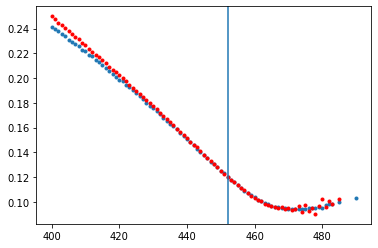

In [41]:
### Plot volatility data ###
x_min = 400
x_max = 495
plot_data = vol_data[(vol_data["Strike"] >= x_min) & (vol_data["Strike"] <= x_max)]
plt.plot(plot_data["Strike"], plot_data["CallImpliedVol"], '.')
plt.plot(plot_data["Strike"], plot_data["PutImpliedVol"], 'r.')
plt.autoscale(enable=True, axis='y')
plt.axvline(x=atm_strike)
plt.show()

In [42]:
### Save to CSV file ###

#Point-out at-the-money strike
vol_data["At-the-money"] = (vol_data["Strike"] == atm_strike)

#Save data to CSV
now = datetime.now()
path = r"vols"
path = os.path.join(path, str(ticker))
series_path = r"series_" + str(expiration_date.year) + r"-" + str(expiration_date.month) + r"-" + str(expiration_date.day)
path = os.path.join(path, series_path)
Path(path).mkdir(parents=True, exist_ok=True)
file_name = str(ticker) + "_series_" + str(expiration_date.month) \
            + r"-" + str(expiration_date.day) + r"_" + str(now.year) + r"-" \
            + str(now.month) + r"-" + str(now.day) +  r".csv"
vol_data.to_csv(os.path.join(path, file_name), index=False)

In [43]:

print(vol_data)

     Strike  CallImpliedVol  PutImpliedVol  At-the-money
0     250.0             NaN       0.610718         False
1     255.0             NaN       0.591517         False
2     260.0             NaN       0.581233         False
3     265.0             NaN       0.562565         False
4     270.0             NaN       0.552749         False
5     275.0             NaN       0.541367         False
6     280.0             NaN       0.529016         False
7     285.0             NaN       0.516885         False
8     290.0             NaN       0.508791         False
9     295.0             NaN       0.494911         False
10    300.0             NaN       0.485419         False
11    303.0             NaN       0.478592         False
12    305.0             NaN       0.471356         False
13    310.0             NaN       0.459487         False
14    312.0             NaN       0.455393         False
15    313.0             NaN       0.451859         False
16    315.0             NaN    